In [2]:
!pip install osmium

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 1.4 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 1.3 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.7 MB 1.3 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.7 MB 1.3 MB/s eta 0:00:01
   ------------------------------ --------- 1.3/1.7 MB 1.1 MB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 1.0 MB/s eta 0:00:00


In [11]:
%matplotlib inline

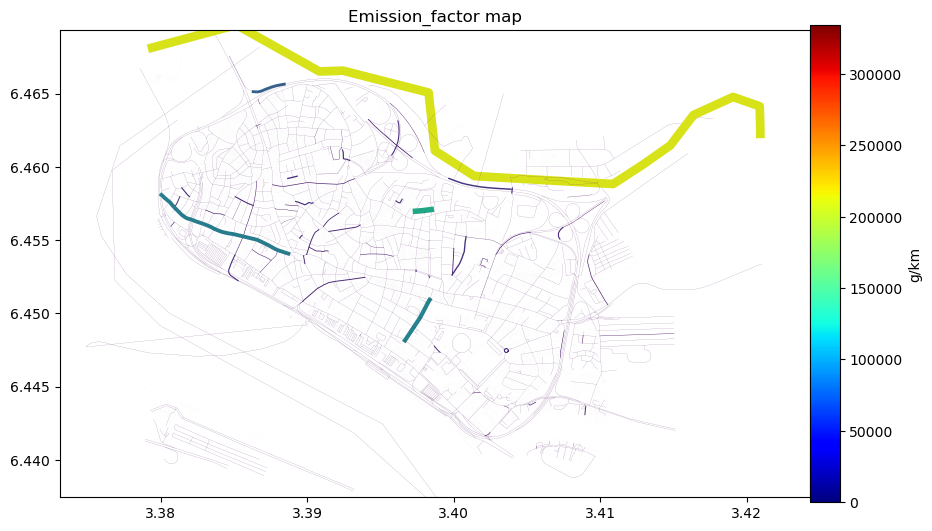

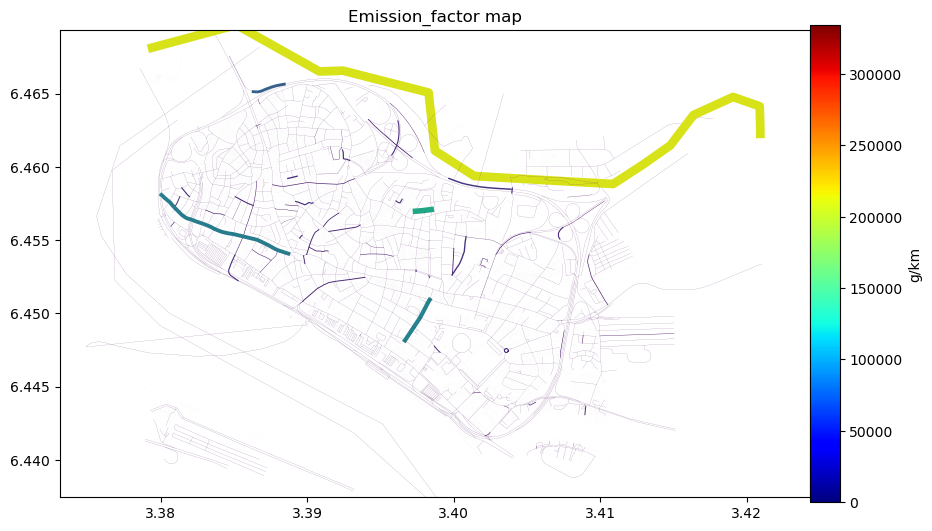

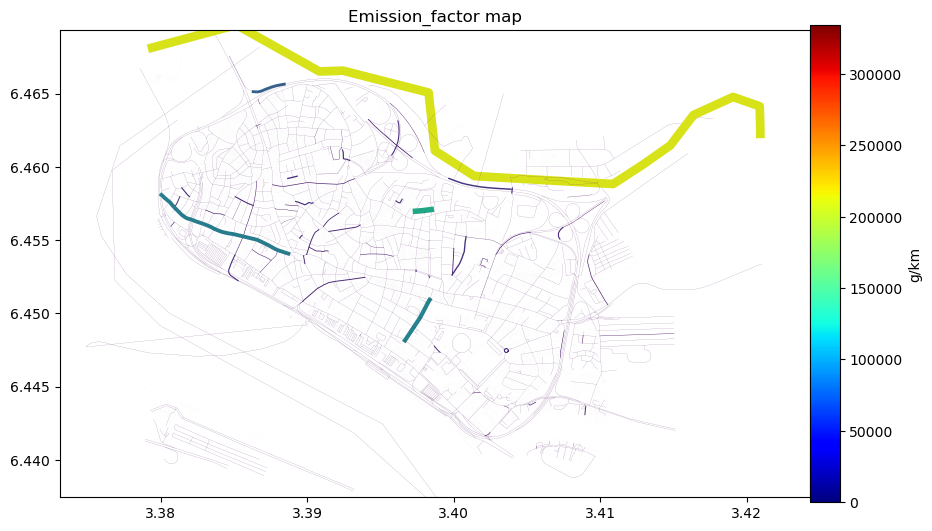

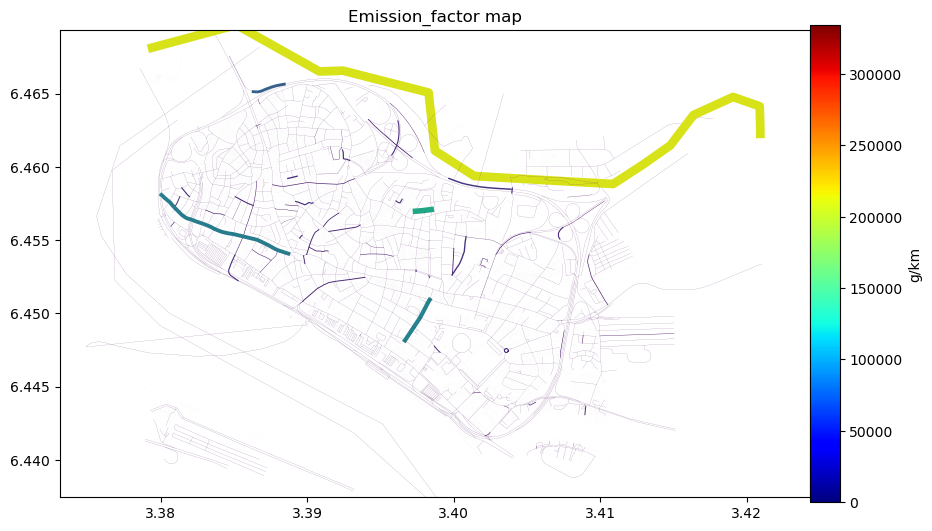

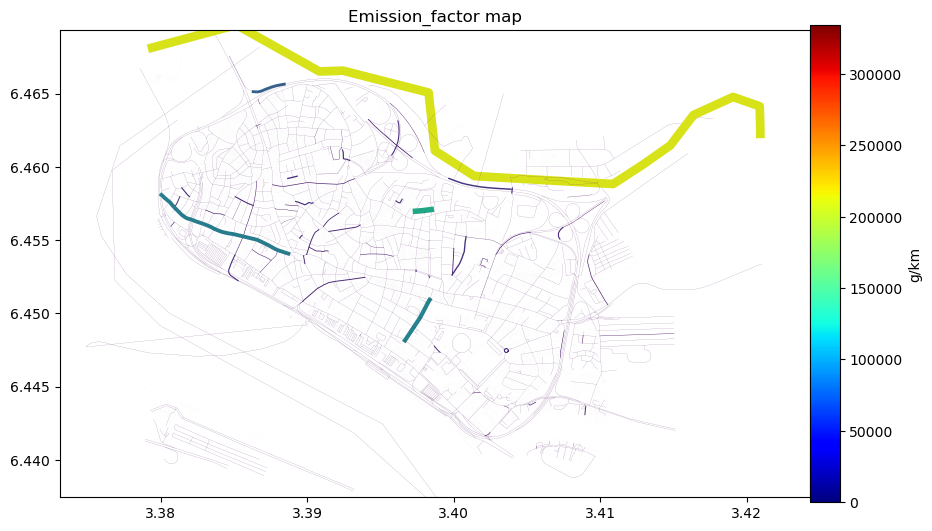

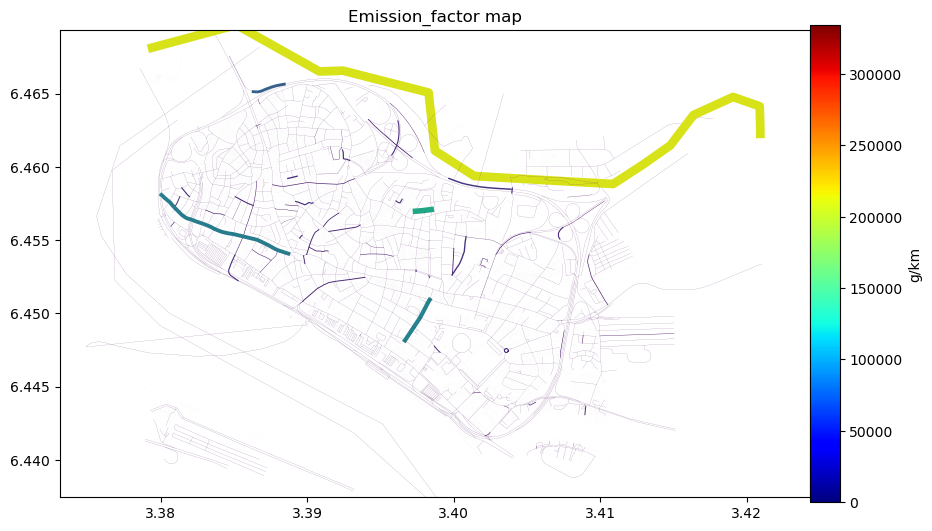

In [18]:
# Copyright (C) 2015, ENPC, INRIA
# Author(s): Ruiwei Chen, Vivien Mallet
#
# This file is part of a program for the computation of air pollutant
# emissions.
# This file is free software; you can redistribute it and/or modify it under
# the terms of the GNU Lesser General Public License as published by the Free
# Software Foundation; either version 2.1 of the License, or (at your option)
# any later version.
#
# This file is distributed in the hope that it will be useful, but WITHOUT ANY
# WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE. See the GNU Lesser General Public License for more
# details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with this file. If not, see http://www.gnu.org/licenses/.

# This example file shows how to compute the hot emissions (in g) for
# passenger cars and display the emission level of streets with OpenStreetMap.

import matplotlib
#matplotlib.use('Agg')

import os
import sys
import copert, osm_network
import numpy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

cop = copert.Copert("input/PC_parameter.csv", "input/LDV_parameter.csv",
                    "input/HDV_parameter.csv", "input/Moto_parameter.csv")

### Importing data files

# All text data files contain 25 lines, that is, one for each street.

# Description of the links in two columns: length in km and OpenStreetMap way
# ID. There is exactly one line per link.
data_link = numpy.loadtxt("input/link_osm.dat")


# Vehicle engine type.
engine_type = [cop.engine_type_gasoline, cop.engine_type_diesel] 
engine_type_m = [cop.engine_type_moto_two_stroke_more_50, cop.engine_type_moto_four_stroke_50_250]
# Proportion of gasoline cars -- the rest is assumed to be diesel.
# data_gasoline_proportion = numpy.loadtxt("input/gasoline_proportion.dat")

# The three engine capacities are below 1.4 l, in [1.4 l, 2 l] and above 2
# l. In practice, we assign the following capacities (each of which falls
# uniquely in a category):
# engine_capacity = [1.3, 1.8, 2.1]
engine_capacity = [cop.engine_capacity_0p8_to_1p4,
                   cop.engine_capacity_1p4_to_2]

# Proportion of engines in each of the three capacities, for gasoline cars.
data_engine_capacity_gasoline \
    = numpy.loadtxt("input/engine_capacity_gasoline.dat")
# Proportion of engines in each of the three capacities, for diesel cars.
data_engine_capacity_diesel \
    = numpy.loadtxt("input/engine_capacity_diesel.dat")


# There are 14 COPERT categories, following the order from class 'Copert':
copert_class = [cop.class_PRE_ECE, cop.class_ECE_15_00_or_01,
                cop.class_ECE_15_02, cop.class_ECE_15_03, cop.class_ECE_15_04,
                cop.class_Improved_Conventional, cop.class_Open_loop,
                cop.class_Euro_1, cop.class_Euro_2, cop.class_Euro_3,
                cop.class_Euro_4, cop.class_Euro_5, cop.class_Euro_6,
                cop.class_Euro_6c]
Nclass = len(copert_class) # should be 14.

copert_class_motorcycle = [cop.class_moto_Conventional, cop.class_moto_Euro_1, 
			   cop.class_moto_Euro_2, cop.class_moto_Euro_3,
                	   cop.class_moto_Euro_4, cop.class_moto_Euro_5]
Mclass = len(copert_class_motorcycle) # should be 6

# Proportion of each COPERT class for gasoline cars.
data_copert_class_gasoline \
    = numpy.loadtxt("input/copert_class_proportion_gasoline.dat")
# Proportion of each COPERT class for diesel cars.
data_copert_class_diesel \
    = numpy.loadtxt("input/copert_class_proportion_diesel.dat")

# Proportion of each COPERT class for moped 2-stroke >50cm3 and <250cm3.
data_copert_class_motorcycle_two_stroke \
    = numpy.loadtxt("input/copert_class_proportion_2_stroke_motorcycle_more_50.dat")

# Proportion of each COPERT class for moped 4-stroke >50cm3 and <250cm3.
data_copert_class_motorcycle_four_stroke \
    = numpy.loadtxt("input/copert_class_proportion_4_stroke_motorcycle_50_250.dat")


### Computing the emissions

#for passenger car and motorcycles

Nlink = data_link.shape[0]
hot_emission_pc = numpy.zeros((Nlink, ), dtype = float)
hot_emission_m = numpy.zeros((Nlink, ), dtype = float)
hot_emission = numpy.zeros((Nlink, ), dtype = float)

for i in range(Nlink):
    v = min(max(10., data_link[i, 3]), 130.)
    link_length = data_link[i, 0]
    link_id = data_link[i, 1]
    link_flow = data_link[i, 2]
    link_speed = data_link[i, 3]
    link_gasoline_proportion = data_link[i, 4]
    link_pc_proportion = data_link[i, 5]
    link_4_stroke_proportion = data_link[i, 6]

    # Passenger car,motorcycle, 2_stroke proportion.
    p_passenger = link_gasoline_proportion
    P_motorcycle = 1. - link_pc_proportion

    # Diesel and gasoline proportions.

    engine_type_distribution = [link_gasoline_proportion,
                                1. - link_gasoline_proportion]
    engine_capacity_distribution = [data_engine_capacity_gasoline[i],
                                    data_engine_capacity_diesel[i]]
#   4-stroke 2-stroke proportions.

    engine_type_motorcycle_distribution = [link_4_stroke_proportion,
                                1. - link_4_stroke_proportion]
#   passenger car emission
    for t in range(2): # gasoline/diesel or 2-stroke/4-stroke
        for c in range(Nclass) :
          for k in range(2): # engine capacities
                if (copert_class[c] != cop.class_Improved_Conventional
                    and copert_class[c] != cop.class_Open_loop) \
                    or engine_capacity[k] <= 2.0:
                    # No formula available for diesel passenger cars whose
                   # engine capacity is less than 1.4 l and the copert class
                   # is Euro 1, Euro 2 or Euro 3.
                    if t == 1 and k == 0  \
                       and copert_class[c] in range(cop.class_Euro_1,
                                                  1 + cop.class_Euro_3):
                        continue
                    e = cop.Emission(cop.pollutant_CO, v, link_length,
                                     cop.vehicle_type_passenger_car, engine_type[t],
                                     copert_class[c], engine_capacity[k], 28.2)
                    e *= engine_type_distribution[t] \
                        * engine_capacity_distribution[t][k]
                    hot_emission_pc[i] += e * p_passenger / link_length * link_flow

#   for motorcycle
    for m in range(2): # 2-stroke/4-stroke 
       for d in range (Mclass):
            if m == 1 \
            and copert_class_motorcycle[d] in range(cop.class_moto_Conventional,
                                                          1 + cop.class_moto_Euro_5):
              continue
            e_f = cop.EFMotorcycle(cop.pollutant_CO, v, engine_type_m[m], copert_class_motorcycle[d]) 
            e_f *= engine_type_motorcycle_distribution[m]

            hot_emission_m[i] += e_f * P_motorcycle * link_flow 
    hot_emission[i] = hot_emission_m[i] + hot_emission_pc[i]	
f_emission_link = "output/link_hot_emission_factor.txt"
numpy.savetxt(f_emission_link, hot_emission, fmt = '%10.5f', delimiter = ',', )

### Plotting the emissions using OpenStreetMap
osm_file = "input/selected_zone-lagos.osm"

# Number of cores in use during the parsing of the OSM file.
Ncore = 8

# Tolerance for the search of node ids in the vicinity of the domain.
tolerance = 0.005

# Zoomed domain for plotting emissions
x_max = 3.42430
x_min = 3.37310
y_max = 6.46934
y_min = 6.43744

# Domain to be displayed.
selected_zone = [[x_min, y_max],
                 [x_min, y_min],
                 [x_max, y_min],
                 [x_max, y_max]]
selected_zone.append(selected_zone[0]) # to close the polygon correctly.

# Retrieving the coordinates and IDs of the highways.
highway_coordinate, highway_osmid \
    = osm_network.retrieve_highway(osm_file, selected_zone, tolerance, Ncore)


# Use numpy.max() to get the true maximum value and add a small epsilon
max_emission_value = numpy.max(hot_emission)
epsilon = 1e-9 # A tiny float value

# Line width associated to the largest emission.
lw_max = .00004
lw_min = .00002
# Use the robust epsilon fix for width_scaling:
width_scaling = (lw_max - lw_min) / (max_emission_value + epsilon) + lw_min

# Line width associated to the highways without known emissions.
lw_nodata = .003

# Use the epsilon-adjusted vmax for normalization
color_scale  = colors.Normalize(vmin = 0, vmax = max_emission_value + epsilon)
scale_map = cmx.ScalarMappable(norm = color_scale)

# Get the OSM way IDs of the links.
emission_osm_id = [int(x) for x in data_link[:, 1]]

fig = plt.figure(figsize=(10, 9), dpi=100)

# Emissions.
ax = fig.add_axes([0.1, 0.1, 0.75, 0.75])
ax.set_aspect("equal", adjustable = "box")

# Colorbar.
ax_c = fig.add_axes([0.85, 0.21, 0.03, 0.53])
cb = matplotlib.colorbar.ColorbarBase(ax_c, cmap = matplotlib.cm.jet,
                                       norm = color_scale,
                                       orientation = "vertical")
cb.set_label("g/km")

# Loops over the highways (i.e., streets).
for refs, osmid in zip(highway_coordinate, highway_osmid):

    try:
        # Finding the emission link associated with the highway.
        i = emission_osm_id.index(osmid)
    except: # No emission on this highway.
        i = None

    if i != None:
        current_emission = hot_emission[i]
        
        color_value = scale_map.to_rgba(current_emission)
            
        ax.plot([x[0] for x in refs], [x[1] for x in refs],
                color = color_value,
                lw = current_emission * width_scaling)
                
    else: # no emission.
        ax.plot([x[0] for x in refs], [x[1] for x in refs],
                "k-", lw = lw_nodata)

# Final plotting commands (added here, were missing in user prompt)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title("Emission_factor map")
plt.savefig("output/map_CO_with_osm.png")

plt.show()